In [1]:
import sys
sys.path.append("../../smsl")

In [2]:
import numpy as np
import matplotlib.pyplot as plt

### Part 1: Initialize

In [3]:
pymol = '/opt/PyMOL-2.5.5_496-Linux-x86_64-py37/pymol/bin/pymol'

In [4]:
from smsl.makeDataframe import SpringAgent

In [5]:
sp_agent = SpringAgent()
sp_agent.load_TimeAgent()
sp_agent.read_all_k_b0_pairtype_df()

Reading data from: /home/user/workfolder/g4dna_protocol_demo/hybrid-ii_wttel26/d.fluctmatch/bigtraj_fluctmatch/0000_0500/result/pairtypes_k_b0_cutoff_5.00.csv
Reading data from: /home/user/workfolder/g4dna_protocol_demo/hybrid-ii_wttel26/d.fluctmatch/bigtraj_fluctmatch/0250_0750/result/pairtypes_k_b0_cutoff_5.00.csv
Reading data from: /home/user/workfolder/g4dna_protocol_demo/hybrid-ii_wttel26/d.fluctmatch/bigtraj_fluctmatch/0500_1000/result/pairtypes_k_b0_cutoff_5.00.csv
Reading data from: /home/user/workfolder/g4dna_protocol_demo/hybrid-ii_wttel26/d.fluctmatch/bigtraj_fluctmatch/0750_1250/result/pairtypes_k_b0_cutoff_5.00.csv
Reading data from: /home/user/workfolder/g4dna_protocol_demo/hybrid-ii_wttel26/d.fluctmatch/bigtraj_fluctmatch/1000_1500/result/pairtypes_k_b0_cutoff_5.00.csv
Reading data from: /home/user/workfolder/g4dna_protocol_demo/hybrid-ii_wttel26/d.fluctmatch/bigtraj_fluctmatch/1250_1750/result/pairtypes_k_b0_cutoff_5.00.csv
Reading data from: /home/user/workfolder/g4dna

### Part2: Visualize Pairs by Pymol

In [6]:
def color2hex(m):
    if ('dd' in m) or ('dg' in m):
        color = f'0x7a10de'
    elif ('bm' in m) or ('mm' in m):
        color = f'0xde56c9'
    elif 'hb' in m:
        color = f'0xcc0000'
    elif ('ls_st' in m) or ('ll_st' in m):
        color = f'0xab7eea'
    elif ('ss_st' in m) or ('cs_st' in m):
        color = f'0xf8cf52' 
    elif 'rb' in m:
        color = f'0x73dac3'
    elif 'pr' in m: ## pr0, pr1
        color = f'0x7e82ea'
    else:
        color = f'0xffffff'
    return color

def generate_dash_cmd(df, c='', upper=10, lower=3.0):
    dash = ""
    dist_id = 0
    for idx, df_line in df.iterrows():
        id1, id2, k0 = df_line['Atomid_i'], df_line['Atomid_j'], df_line['k']
        if k0 >= lower:
            dist_id += 1
            trans = max(1-k0/upper, 0.0)
            color = color2hex(c)
            dash += f'distance dist_{c}_{dist_id:02}, ID {id1}, ID {id2}\n'
            dash += f'set dash_color, {color}, dist_{c}_{dist_id:02}\n'
            dash += f'set dash_transparency, {trans:.3f}, dist_{c}_{dist_id:02}\n'
            dash += f'pseudoatom ps_{c}_{dist_id:02}, id {id1}+{id2}, state=-1\n'
            dash += f'label ps_{c}_{dist_id:02}, {k0:.2f}\n'
    return dash

In [7]:
def generate_pse(self, run_pymol=True):
    script_dash, script_enm, script_struct, script_group  = "", "", "", ""
    for time_label, st_agent in self.t_agent.items():
        script_enm    += f'load {st_agent.enmcrd_file}, object=na_enm_{time_label}\n'
        script_struct += f'load {st_agent.inpcrd_file}, object={st_agent.system}_{time_label}\n'
    script_enm    += f'join_states na_enm, na_enm_*\n'
    script_enm    += f'delete na_enm_*\n'
    script_struct += f'join_states {self.system}, {self.system}_*\n'
    script_struct += f'delete {self.system}_*\n'
    df = self.t_agent.mean.df_all_k
    for category in np.unique(df["Category"]):
        mask_category = df["Category"]==category
        df_category = df[mask_category]
        if len(df_category)==0: continue
        upper, lower = np.percentile(df_category['k'], 95), np.percentile(df_category['k'], 80)
        script_dash  += generate_dash_cmd(df_category, category, upper, lower)
        script_group += f"group {category}, dist_{category}* ps_{category}* struct_{category} \n"
        script_group += f"disable {category} \n"
    pse_file = f'{self.t_agent.mean.result_folder}/{self.system}.k_all.pse'
    pml = f'''\
{script_enm}\
{script_dash}\
{script_struct}\
{script_group}\
## show structure style
set dash_gap, 0
set sphere_scale, 0.2
show_as stick, {self.system} and polymer.nucleic
hide labels, dist*
hide wire, ps*
disable na_enm
color potassium, elem POT
color green  , (resn ADE or resn DA) and elem C
color yellow , (resn CYT or resn DC) and elem C
color red    , (resn THY or resn DT) and elem C
color magenta, (resn GUA or resn DG) and elem C
save {pse_file}
    '''
    f = open('.temp.pml', 'w')
    f.write(pml)
    f.close()
    if run_pymol:
        !{pymol} -c .temp.pml > .temp.dat
        print(f'Run bash to check$\n{pymol} {pse_file}')
    else:
        print(pml)
    
generate_pse(sp_agent, run_pymol=True)

Run bash to check$
/opt/PyMOL-2.5.5_496-Linux-x86_64-py37/pymol/bin/pymol /home/user/workfolder/g4dna_protocol_demo/hybrid-ii_wttel26/d.fluctmatch/bigtraj_fluctmatch/0000_5000/result/hybrid-ii.k_all.pse


### Part3: Checking All P-O1P Bonds

In [8]:
df = sp_agent.t_agent.mean.df_all_k
mask_P_O1P = np.logical_and(df['Atomname_i']=='P', df['Atomname_j']=='O1P')
mask_diff_1 = df['Resid_i']-df['Resid_j']==0
indexs = df[mask_P_O1P & mask_diff_1].index

resnresid2ks = {}
for index in indexs:
    data = []
    resid = df.loc[index]['Resid_i']
    resnresid = sp_agent.strandid2sequence['STRAND1'][resid]+str(resid)
    for time_label, st_agent in sp_agent.t_agent.items():
        data.append(st_agent.df_all_k.loc[index]['k'])
    resnresid2ks[resnresid] = data

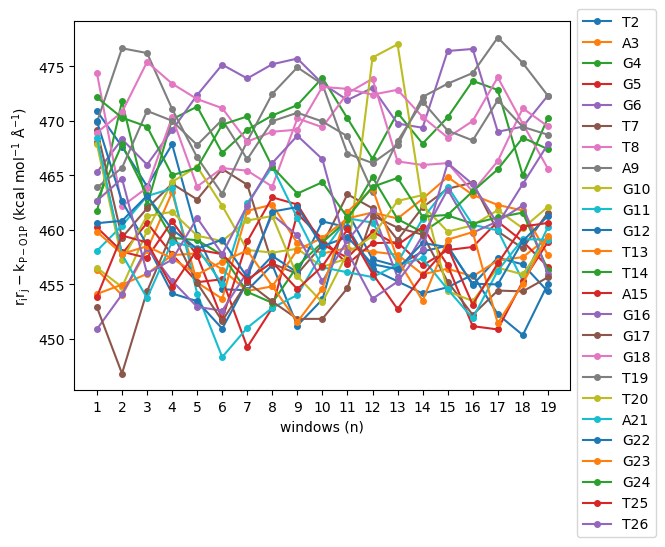

In [9]:
for resnresid, ks in resnresid2ks.items():
    plt.plot(range(1, len(ks)+1), ks, marker='o', label=resnresid, markersize=4)
plt.xlabel('windows (n)')
plt.ylabel(r'$\rm{r}_i\rm{r}_j-k_{\rm{P-O1P}}$ (kcal mol$^{-1}$ Å$^{-1}$)')
plt.xticks(range(1, len(ks)+1))
plt.legend(bbox_to_anchor=[1.0, 1.05])